## Transfer Learning : classification d’images médicales à partir de modèles pré-entraînés de type CNN.

# Contexte du projet

Une équipe médicale souhaite tester l’apport de l’intelligence artificielle dans le diagnostic automatisé de la pneumonie à partir de radios thoraciques. Elle a besoin d’un prototype fonctionnel (Proof of Concept) permettant de démontrer la faisabilité d’un système de classification binaire d’images médicales.
Le problème posé consiste à réutiliser un modèle de vision par ordinateur pré-entraîné (type CNN) pour l’adapter au contexte médical, sans repartir d’un entraînement complet.
Dans une logique de mise en production à moyen terme, il est également attendu de documenter et tracer les expérimentations réalisées. L’usage de MLflow est proposé pour initier cette démarche, en assurant le suivi des performances, la traçabilité des essais et la gestion des versions de modèles dans une perspective MLOps.

# 1. Importer les bibliothèques nécessaires
---

In [45]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.keras
import cv2
import re
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D

np.set_printoptions(linewidth=np.inf)
np.set_printoptions(edgeitems=30)


# 2. Initialisation de MLflow
---

In [46]:
if not os.path.exists("mlruns"):
    os.makedirs('mlruns')
mlflow.set_tracking_uri(uri = "file:./mlruns")
mlflow.set_experiment("pneumonia_classification")

<Experiment: artifact_location='file:///Users/wassim/Desktop/Simplon/Brief/Brief_2/CNN-Transfer-Learning/mlruns/440693512193937605', creation_time=1747899191601, experiment_id='440693512193937605', last_update_time=1747899191601, lifecycle_stage='active', name='pneumonia_classification', tags={}>

# 3. Exploration des données
---

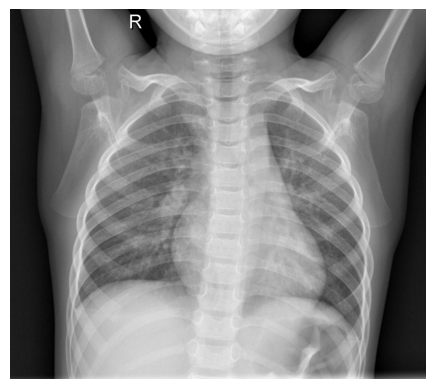

Shape (dimensions)    : (1858, 2090)
Type des valeurs      : uint8


In [47]:
# Chargement d'une image depuis un chemin local
img = cv2.imread("./data/chest_xray/train/NORMAL/IM-0115-0001.jpeg", cv2.IMREAD_GRAYSCALE)


# Visualisation de l'image
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

# Inspection des métadonnées de l'image

print(f"Shape (dimensions)    : {img.shape}")
print(f"Type des valeurs      : {img.dtype}")

# 4. Chargement des données
---

In [48]:
# chemin vers les dossiers contenant les images

train_dir = "./data/chest_xray/train"
test_dir = "./data/chest_xray/test"
val_dir = "./data/chest_xray/val"

# Paramétrés
target_size = (224, 224)
batch_size = 32
epochs = 10

# générateur d'images pour le jeu d'entraînement avec une augmentation des données
train_datagen = ImageDataGenerator(
    rescale = 1./255,  # Normalisation des pixels entre 0 et 1
    rotation_range = 15,  # Rotation aléatoire des images
    zoom_range = 0.1, # Zoom aléatoire
    width_shift_range = 0.1,  # Décalage horizontal aléatoire
    height_shift_range = 0.1,  # Décalage vertical aléatoire
    horizontal_flip = True, # Miroir horizontal aléatoire
)

# générateur d'images pour le jeu de validation et de test
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)



In [49]:
# Creation des générateurs d'images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary",
    color_mode="rgb",
    shuffle=True,
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False,
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False,
)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# 5. Création du modèle
---


### 5.1 Chargement du modèle pré-entraîné MobileNetV2


In [50]:
def build_mobileNetV2_model(input_shape = (224,224,3)):
    base_model = MobileNetV2(
        weights = "imagenet",
        include_top = False,
        input_shape = input_shape,
    )
    base_model.trainable = False  # On gèle les poids du modèle pré-entraîné
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Ajout d'une couche de pooling global
    x = Dense(1, activation="sigmoid")(x)

    model = Model(inputs = base_model.input, outputs = x)
    return model


### 5.2 Chargement du modèle pré-entraîné DenseNet121

In [51]:
def build_denseNet121_model(input_shape = (224,224,3)):
    base_model = DenseNet121(
        weights = "imagenet",
        include_top = False,
        input_shape = input_shape,
    )
    base_model.trainable = False  # On gèle les poids du modèle pré-entraîné
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Ajout d'une couche de pooling global
    x = Dense(1, activation="sigmoid")(x)

    model = Model(inputs = base_model.input, outputs = x)
    return model


### 5.3.1 Connection du mlflow au modèle MobileNetV2

In [54]:
def get_next_run_name(model_name, experiment_name="pneumonia_classification"):
    '''
    Fonction pour générer un nom de run unique pour chaque exécution de modèle dans MLflow.
    Le nom du run est basé sur le nom du modèle et le numéro d'exécution.
    '''
    experiment = mlflow.get_experiment_by_name(experiment_name)
    experiment_id = experiment.experiment_id

    runs = mlflow.search_runs(experiment_ids=[experiment_id])
    run_names = runs["tags.mlflow.runName"] if "tags.mlflow.runName" in runs.columns else []
    if len(run_names) == 0:
        return f"{model_name} run 1"


    pattern = rf"{re.escape(model_name)} run (\d+)"
    existing_nums = [int(re.search(pattern, name).group(1))
                     for name in run_names if re.search(pattern, name)]

    next_run_number = max(existing_nums) + 1 if existing_nums else 1
    return f"{model_name} run {next_run_number}"

In [56]:
run_name = get_next_run_name("MobileNetV2")

with mlflow.start_run(run_name=run_name):
    mlflow.log_param("model_name", "MobileNetV2")
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)

    model = build_mobileNetV2_model()
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs = epochs,
    )
    mlflow.keras.log_model(model, "MobileNetV2")

    final_val_acc = history.history["val_accuracy"][-1]
    mlflow.log_metric("val_accuracy", final_val_acc)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 46s 273ms/step - accuracy: 0.8160 - loss: 0.3912 - val_accuracy: 0.7500 - val_loss: 0.4664
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 269ms/step - accuracy: 0.9355 - loss: 0.1697 - val_accuracy: 0.7500 - val_loss: 0.4023
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 46s 278ms/step - accuracy: 0.9417 - loss: 0.1388 - val_accuracy: 0.9375 - val_loss: 0.2623
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 287ms/step - accuracy: 0.9505 - loss: 0.1313 - val_accuracy: 0.8750 - val_loss: 0.2482
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 271ms/step - accuracy: 0.9482 - loss: 0.1229 - val_accuracy: 0.8125 - val_loss: 0.3040
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 273ms/step - accuracy: 0.9548 - loss: 0.1132 - val_accuracy: 0.8125 - val_loss: 0.3439
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 274ms/step - accuracy: 0.9659 - loss: 0.0945 - val_accuracy: 0.8125 - val_loss: 0.2551
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 275ms/step - accuracy: 0.9641 - loss: 0

2025/05/22 16:25:02 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/22 16:25:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### 5.3.2 Connection du mlflow au modèle DenseNet121


In [60]:
run_name = get_next_run_name("DenseNet121")
with mlflow.start_run(run_name=run_name):
    mlflow.log_param("model_name", "DenseNet121")
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)

    model = build_denseNet121_model()
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs = epochs,
    )
    mlflow.keras.log_model(model, "DenseNet121")

    final_val_acc = history.history["val_accuracy"][-1]
    mlflow.log_metric("val_accuracy", final_val_acc)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 640ms/step - accuracy: 0.7740 - loss: 0.4475 - val_accuracy: 0.6875 - val_loss: 0.5016
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 645ms/step - accuracy: 0.9134 - loss: 0.2153 - val_accuracy: 0.6875 - val_loss: 0.4947
Epoch 3/10
 35/163 ━━━━━━━━━━━━━━━━━━━━ 1:21 641ms/step - accuracy: 0.9407 - loss: 0.1796

KeyboardInterrupt: 